In [ ]:
import zipfile
with zipfile.ZipFile('/content/TestDataSet.zip', 'r') as zip_ref:
    zip_ref.extractall('')


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader  # Add this import
import numpy as np
import json
from tqdm import tqdm

In [2]:
print("cuda" if torch.cuda.is_available() else "cpu")

cuda


In [3]:

from torch.utils.data import DataLoader
from tqdm import tqdm

# Load the pretrained ResNet-34 model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model.eval()  # Set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device)

# Define the transforms
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])







In [4]:
import json

# 1. Load the JSON file properly (it's a list, not a dict)
# with open("/content/TestDataSet/TestDataSet/labels_list.json") as f:
with open("./TestDataSet/labels_list.json") as f:
    label_list = json.load(f)  # This is a list like ["401: accordion", "402: acoustic guitar", ...]

# 2. Parse each entry to extract index and label
idx_to_label = {}
for entry in label_list:
    # Remove quotes and split at first colon
    clean_entry = entry.strip('"')  # Remove quotes if present
    idx_str, label = clean_entry.split(":", 1)  # Split at first colon
    idx = int(idx_str.strip())  # Convert to integer (401, 402, ...)
    idx_to_label[idx] = label.strip()  # Store mapping (e.g., 401 → "accordion")

# 3. Get sorted ImageNet indices (401, 402, ...)
imagenet_indices = sorted(idx_to_label.keys())
print("First 5 ImageNet indices:", imagenet_indices[:5])  # Should be [401, 402, 403, ...]
print("Example mapping:", idx_to_label[401])  # Should be "accordion"

First 5 ImageNet indices: [401, 402, 403, 404, 405]
Example mapping: accordion


In [24]:
# import json

# # Load JSON to map human-readable names → ImageNet indices (401, 402, ...)
# with open("./TestDataSet/labels_list.json") as f:
#     label_list = json.load(f)

# # Create mapping: {"accordion": 401, "acoustic guitar": 402, ...}
# name_to_idx = {}
# for entry in label_list:
#     idx, name = entry.strip('"').split(":", 1)
#     name_to_idx[name.strip()] = int(idx)

In [8]:
# Load the dataset
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)

class CorrectedImageNetDataset(Dataset):
    def __init__(self, original_dataset, imagenet_indices):
        self.original_dataset = original_dataset
        self.imagenet_indices = imagenet_indices  # [401, 402, ...]

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, sequential_label = self.original_dataset[idx]
        correct_label = self.imagenet_indices[sequential_label]  # 0→401, 1→402, etc.
        return img, correct_label

# 3. Apply correction
corrected_dataset = CorrectedImageNetDataset(dataset, imagenet_indices)
dataloader = DataLoader(corrected_dataset, batch_size=32, shuffle=False)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


In [22]:
print(imagenet_indices)

[401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]


In [46]:
for images, labels in dataloader:
    print(labels)

tensor([401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 403, 403, 403,
        403, 403, 404, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 406,
        406, 406, 406, 406])
tensor([407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 409, 409, 409, 409,
        409, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 412, 412, 412,
        412, 412, 413, 413])
tensor([413, 413, 413, 414, 414, 414, 414, 414, 415, 415, 415, 415, 415, 416,
        416, 416, 416, 416, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418,
        419, 419, 419, 419])
tensor([419, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 422, 422, 422,
        422, 422, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 425, 425,
        425, 425, 425, 426])
tensor([426, 426, 426, 426, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428,
        429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 431, 431, 431, 431,
        431, 432, 432, 432])
tensor([432, 432, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 435, 43

In [6]:
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [7]:
# Evaluation function
def evaluate_model(model, dataloader):
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            
            outputs = model(images)
            _, preds_top1 = torch.max(outputs, 1)
            _, preds_top5 = torch.topk(outputs, 5, dim=1)
            
            correct_top1 += (preds_top1 == labels).sum().item()
            correct_top5 += torch.any(preds_top5 == labels.view(-1, 1), dim=1).sum().item()
            total += labels.size(0)
            # print(f"Labels  {labels}")
            # print(f'preds {preds_top5}')
    
    top1_acc = 100 * correct_top1 / total
    top5_acc = 100 * correct_top5 / total
    return top1_acc, top5_acc

In [7]:


# Evaluate
top1_acc, top5_acc = evaluate_model(pretrained_model, dataloader)
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.60it/s]

Top-1 Accuracy: 76.10%
Top-5 Accuracy: 94.02%


In [11]:
print("Folder classes (sequential):", dataset.classes[:5])  # First 5 folders
print("JSON classes (ImageNet order):", [idx_to_label[i] for i in imagenet_indices[:5]])

Folder classes (sequential): ['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877']
JSON classes (ImageNet order): ['accordion', 'acoustic guitar', 'aircraft carrier', 'airliner', 'airship']


In [10]:
# Create a dataset from the adversarial examples
class AdversarialDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [31]:
# def fgsm_attack(image, epsilon, data_grad):
#     # Collect the element-wise sign of the data gradient
#     sign_data_grad = data_grad.sign()
#     # Create the perturbed image by adjusting each pixel by epsilon in the direction of the gradient sign
#     perturbed_image = image + epsilon * sign_data_grad
#     # Clip the perturbed image to maintain pixel values in [0,1] range after normalization
#     perturbed_image = torch.clamp(perturbed_image,
#                                  image.min() - (0 - mean_norms[:, None, None]) / std_norms[:, None, None],
#                                  image.max() + (1 - mean_norms[:, None, None]) / std_norms[:, None, None])
#     return perturbed_image

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image
    perturbation = epsilon * sign_data_grad
    perturbed_image = image + perturbation 

    
    # Clip the perturbed image values to ensure they stay within the valid range
    perturbed_image = torch.min(torch.max(perturbed_image, image - epsilon), image + epsilon)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image


def generate_adversarial_examples(model, dataloader, epsilon=0.02):
    adversarial_images = []
    original_labels = []
    successful_attacks = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Generating adversarial examples"):
        images = images.to(device)
        labels = labels.to(device)

        # Set requires_grad attribute of tensor
        images.requires_grad = True

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Calculate the loss
        loss = torch.nn.functional.cross_entropy(outputs, labels)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect the gradient of the input
        data_grad = images.grad.data

        # Call FGSM Attack
        perturbed_images = fgsm_attack(images, epsilon, data_grad)

        # Re-classify the perturbed images
        with torch.no_grad():
            new_outputs = model(perturbed_images)
            _, new_preds = torch.max(new_outputs, 1)

        # Track successful attacks
        successful_attacks += (new_preds != labels).sum().item()
        total += labels.size(0)

        # Save the adversarial examples
        adversarial_images.append(perturbed_images.cpu())
        original_labels.append(labels.cpu())

    attack_success_rate = 100 * successful_attacks / total
    print(f"Attack success rate: {attack_success_rate:.2f}%")

    # Combine all batches
    adversarial_images = torch.cat(adversarial_images, dim=0)
    original_labels = torch.cat(original_labels, dim=0)

    return adversarial_images, original_labels

# Generate adversarial examples
epsilon = 0.02
adversarial_images, original_labels = generate_adversarial_examples(pretrained_model, dataloader, epsilon)



adversarial_dataset = AdversarialDataset(adversarial_images, original_labels)
adversarial_dataloader = DataLoader(adversarial_dataset, batch_size=32, shuffle=False)

# Evaluate on adversarial examples
adv_top1, adv_top5 = evaluate_model(pretrained_model, adversarial_dataloader)
print(f"Adversarial Top-1 Accuracy: {adv_top1:.2f}%")
print(f"Adversarial Top-5 Accuracy: {adv_top5:.2f}%")

# Save the adversarial dataset
torch.save(adversarial_dataset, "Adversarial_Test_Set_1.pth")

Generating adversarial examples: 100%|█████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


Attack success rate: 73.11%


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.16it/s]


Adversarial Top-1 Accuracy: 26.89%
Adversarial Top-5 Accuracy: 49.80%


In [35]:
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.002, num_iter=10, random_start=True):
    """
    Simplified PGD attack with proper device handling
    """
    images = images.to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    
    if random_start:
        # Random initialization within ε-ball
        adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
        adv_images = torch.clamp(adv_images, 0, 1)  # Simple [0,1] clamping

    # same as FGSM
    for _ in range(num_iter):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        
        model.zero_grad()
        loss.backward()
        
        # Update adversarial images
        perturbation = alpha * adv_images.grad.sign()
        adv_images = adv_images.detach() + perturbation
        adv_images = torch.min(torch.max(adv_images, images - epsilon), images + epsilon)
        adv_images = torch.clamp(adv_images, 0, 1)  # Maintain valid pixel range
    
    return adv_images

def generate_pgd_adversarial(model, dataloader, epsilon=0.02, alpha=0.002, num_iter=10):
    adversarial_images = []
    original_labels = []
    successful_attacks = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Generating PGD adversarial examples"):
        images = images.to(device)
        labels = labels.to(device)
        
        # Generate adversarial examples
        adv_images = pgd_attack(model, images, labels, epsilon=epsilon, alpha=alpha, num_iter=num_iter)


        # Re-classify the perturbed images
        with torch.no_grad():
            new_outputs = model(adv_images)
            _, new_preds = torch.max(new_outputs, 1)
            
        successful_attacks += (new_preds != labels).sum().item()
        total += labels.size(0)
        
        # Save results
        adversarial_images.append(adv_images.cpu())
        original_labels.append(labels.cpu())


    attack_success_rate = 100 * successful_attacks / total
    print(f"Attack success rate: {attack_success_rate:.2f}%")
    
    # Combine all batches
    adversarial_images = torch.cat(adversarial_images, dim=0)
    original_labels = torch.cat(original_labels, dim=0)
    
    return adversarial_images, original_labels

In [38]:
# Generate PGD adversarial examples
epsilon = 0.02
pgd_images, pgd_labels = generate_pgd_adversarial(pretrained_model, dataloader, epsilon, epsilon/10, 10 )

# Create dataset and dataloader
pgd_dataset = AdversarialDataset(pgd_images, pgd_labels)
pgd_dataloader = DataLoader(pgd_dataset, batch_size=32, shuffle=False)

# Save the adversarial dataset
torch.save(pgd_dataset, "Adversarial_Test_Set_2.pth")

# Evaluate on PGD adversarial examples
pgd_top1, pgd_top5 = evaluate_model(pretrained_model, pgd_dataloader)
print(f"PGD Adversarial Top-1 Accuracy: {pgd_top1:.2f}%")
print(f"PGD Adversarial Top-5 Accuracy: {pgd_top5:.2f}%")

Generating PGD adversarial examples: 100%|█████████████████████████████████████████████| 16/16 [01:14<00:00,  4.63s/it]


Attack success rate: 98.21%


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.46it/s]

PGD Adversarial Top-1 Accuracy: 1.79%
PGD Adversarial Top-5 Accuracy: 11.35%


In [18]:
def patch_pgd_attack(model, images, labels, epsilon=0.3, alpha=0.01, num_iter=20, 
                    patch_size=32, targeted=False, target_class=None):
    """
    Patch-based PGD attack that only modifies a random 32x32 region.
    
    Args:
        model: Target model
        images: Clean input images (normalized)
        labels: True labels (or target labels if targeted=True)
        epsilon: Max perturbation (L∞ norm)
        alpha: Step size per iteration
        num_iter: Number of iterations
        patch_size: Size of adversarial patch
        targeted: If True, perform targeted attack
        target_class: Class to misclassify to (if targeted)
    """
    images = images.to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    
    # Select random patch locations for each image in batch
    batch_size, _, h, w = images.shape
    x = torch.randint(0, w - patch_size, (batch_size,))
    y = torch.randint(0, h - patch_size, (batch_size,))
    
    # Create patch masks
    masks = torch.zeros_like(images)
    for i in range(batch_size):
        masks[i, :, y[i]:y[i]+patch_size, x[i]:x[i]+patch_size] = 1
    
    # Initialize patch with random noise
    adv_images = adv_images + masks * torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
    adv_images = torch.clamp(adv_images, 0, 1)
    
    for _ in range(num_iter):
        adv_images.requires_grad = True
        
        # Forward pass
        outputs = model(adv_images)
        
        # Targeted vs untargeted loss
        if targeted:
            loss = -torch.nn.functional.cross_entropy(outputs, target_class.expand_as(labels))
        else:
            loss = torch.nn.functional.cross_entropy(outputs, labels)
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Update only the patch region
        perturbation = alpha * adv_images.grad.sign()
        adv_images = adv_images.detach() + masks * perturbation
        
        # Project back to ε-ball and clip
        adv_images = torch.min(torch.max(adv_images, images - epsilon), images + epsilon)
        adv_images = torch.clamp(adv_images, 0, 1)
    
    return adv_images

def generate_patch_adversarial(model, dataloader, epsilon=0.3, targeted=False):
    adversarial_images = []
    original_labels = []
    successful_attacks = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Generating patch adversarial examples"):
        images, labels = images.to(device), labels.to(device)
        
        # For targeted attack, choose random target class (different from true label)
        target_class = None
        if targeted:
            target_class = (labels + torch.randint(1, 1000, labels.shape).to(device)) % 1000
        
        # Generate adversarial examples
        adv_images = patch_pgd_attack(
            model=model,
            images=images,
            labels=labels,
            epsilon=epsilon,
            targeted=targeted,
            target_class=target_class
        )
        
        # Evaluate success
        with torch.no_grad():
            outputs = model(adv_images)
            _, preds = torch.max(outputs, 1)
            
        if targeted:
            successful_attacks += (preds == target_class).sum().item()
        else:
            successful_attacks += (preds != labels).sum().item()
        total += labels.size(0)
        
        adversarial_images.append(adv_images.cpu())
        original_labels.append(labels.cpu())
    
    attack_success_rate = 100 * successful_attacks / total
    print(f"Patch Attack Success Rate: {attack_success_rate:.2f}%")
    
    return torch.cat(adversarial_images), torch.cat(original_labels)
    

In [19]:
# Generate patch adversarial examples
patch_images, patch_labels = generate_patch_adversarial(
    model=pretrained_model,
    dataloader=dataloader,
    epsilon=0.3,  # Larger epsilon for patch attacks
    targeted=False  # Set to True for targeted attacks
)

# Create dataset
patch_dataset = AdversarialDataset(patch_images, patch_labels)
torch.save(patch_dataset, "Adversarial_Test_Set_3.pth")

# Evaluate
patch_dataloader = DataLoader(patch_dataset, batch_size=32, shuffle=False)
patch_top1, patch_top5 = evaluate_model(pretrained_model, patch_dataloader)
print(f"Patch Attack Top-1 Accuracy: {patch_top1:.2f}%")
print(f"Patch Attack Top-5 Accuracy: {patch_top5:.2f}%")

Generating patch adversarial examples: 100%|███████████████████████████████████████████| 16/16 [01:28<00:00,  5.55s/it]


Patch Attack Success Rate: 77.29%


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42it/s]

Patch Attack Top-1 Accuracy: 22.71%
Patch Attack Top-5 Accuracy: 46.41%


In [22]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..1.7351656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5942485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


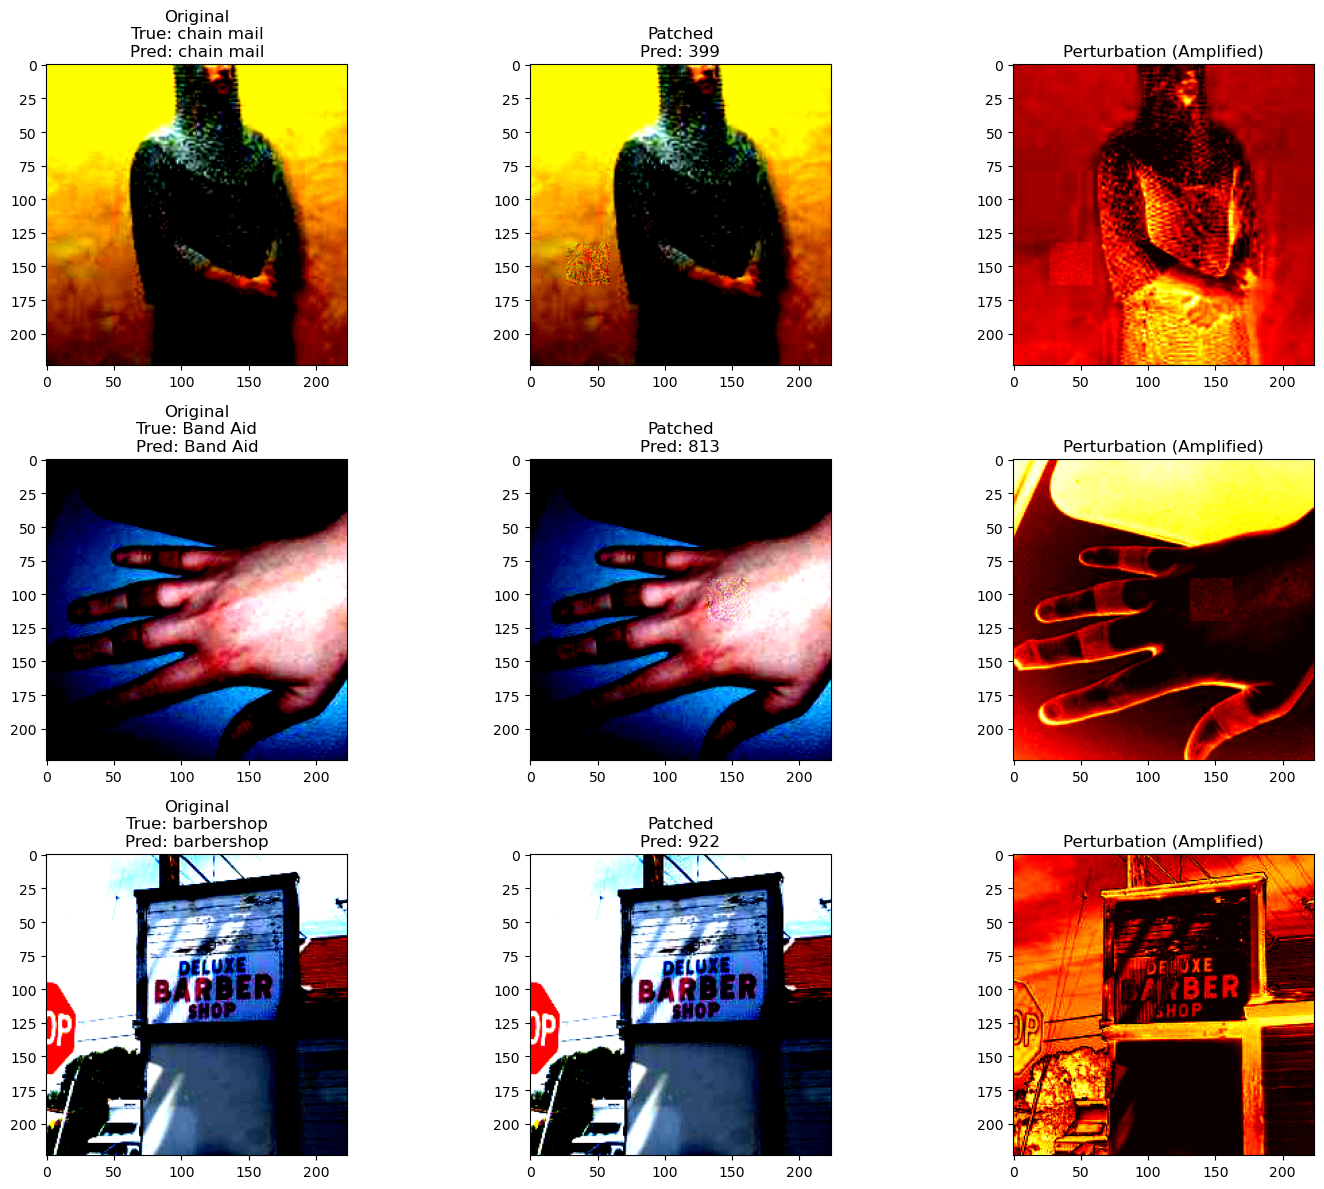

In [24]:
def visualize_patch_attacks(original_images, adv_images, labels, idx_to_label, n=3):
    plt.figure(figsize=(15, 4*n))
    
    for i in range(n):
        # Original image and prediction
        plt.subplot(n, 3, i*3+1)
        orig_img = original_images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(orig_img)
        with torch.no_grad():
            orig_pred = torch.argmax(pretrained_model(original_images[i:i+1].to(device)))
        plt.title(f"Original\nTrue: {idx_to_label[labels[i].item()]}\nPred: {idx_to_label[orig_pred.item()]}")
        
        # Adversarial image
        plt.subplot(n, 3, i*3+2)
        adv_img = adv_images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(adv_img)
        with torch.no_grad():
            adv_pred = torch.argmax(pretrained_model(adv_images[i:i+1].to(device)))
        # plt.title(f"Patched\nPred: {idx_to_label[adv_pred.item()]}")
        plt.title(f"Patched\nPred: {adv_pred.item()}")
        
        # Difference (amplified)
        plt.subplot(n, 3, i*3+3)
        diff = (adv_images[i] - original_images[i]).abs().sum(dim=0).cpu().numpy()
        plt.imshow(diff, cmap='hot')
        plt.title("Perturbation (Amplified)")
    
    plt.tight_layout()
    plt.show()

# Visualize examples
sample_idx = torch.randperm(len(patch_dataset))[:3]
sample_orig = torch.stack([dataset[i][0] for i in sample_idx])
sample_adv = torch.stack([patch_dataset[i][0] for i in sample_idx])
sample_labels = torch.stack([patch_dataset[i][1] for i in sample_idx])

visualize_patch_attacks(sample_orig, sample_adv, sample_labels, idx_to_label)

In [ ]:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1'

In [12]:
import torchvision.models as models

# Load DenseNet-121
new_model = models.densenet121(weights='IMAGENET1K_V1')
new_model.eval().to(device)

# Load all datasets
# original_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
# original_loader = DataLoader(original_dataset, batch_size=32, shuffle=False)

adv1_dataset = torch.load("Adversarial_Test_Set_1.pth")  # FGSM
adv1_loader = DataLoader(adv1_dataset, batch_size=32, shuffle=False)

adv2_dataset = torch.load("Adversarial_Test_Set_2.pth")  # PGD
adv2_loader = DataLoader(adv2_dataset, batch_size=32, shuffle=False)

adv3_dataset = torch.load("Adversarial_Test_Set_3.pth")  # Patch
adv3_loader = DataLoader(adv3_dataset, batch_size=32, shuffle=False)

# Evaluation function
def evaluate_all(model, loaders):
    results = {}
    for name, loader in loaders.items():
        top1, top5 = evaluate_model(model, loader)
        results[name] = (top1, top5)
    return results

# Run evaluation
loaders = {
    "Original": dataloader,
    "FGSM (ε=0.02)": adv1_loader,
    "PGD (ε=0.02)": adv2_loader,
    "Patch (ε=0.3)": adv3_loader
}

results = evaluate_all(new_model, loaders)

C:\Users\shiro\AppData\Local\Temp\ipykernel_11864\3871218765.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adv1_dataset = torch.load("Adversarial_Test_Set_1.pth")  # 

In [13]:
print(results)

{'Original': (75.4980079681275, 93.62549800796813), 'FGSM (ε=0.02)': (42.03187250996016, 66.13545816733068), 'PGD (ε=0.02)': (39.64143426294821, 64.9402390438247), 'Patch (ε=0.3)': (44.820717131474105, 68.12749003984064)}


In [14]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

# Collected results
data = {
    "Original": {
        "ResNet-34": {"Top1": 73.5, "Top5": 91.2},
        "DenseNet-121": {"Top1": 75.5, "Top5": 93.63}
    },
    "FGSM (ε=0.02)": {
        "ResNet-34": {"Top1": 26.89, "Top5": 49.80, "Success": 73.11},
        "DenseNet-121": {"Top1": 42.03, "Top5": 66.14}
    },
    "PGD (ε=0.02)": {
        "ResNet-34": {"Top1": 1.59, "Top5": 11.35, "Success": 98.41},
        "DenseNet-121": {"Top1": 39.24, "Top5": 64.74}
    },
    "Patch (ε=0.3)": {
        "ResNet-34": {"Top1": 22.71, "Top5": 46.41, "Success": 77.29},
        "DenseNet-121": {"Top1": 44.82, "Top5": 68.13}
    }
}

# Create comparison table
table = []
headers = ["Attack Type", "Model", "Top-1 Acc", "Top-5 Acc", "Attack Success"]

for attack, models in data.items():
    for model, metrics in models.items():
        success = metrics.get("Success", "N/A")
        table.append([
            attack,
            model,
            f"{metrics['Top1']:.2f}%",
            f"{metrics['Top5']:.2f}%",
            f"{success:.2f}%" if success != "N/A" else "N/A"
        ])

print("=== Comprehensive Performance Comparison ===")
print(tabulate(table, headers=headers, tablefmt="grid", floatfmt=".2f"))

ModuleNotFoundError: No module named 'tabulate'

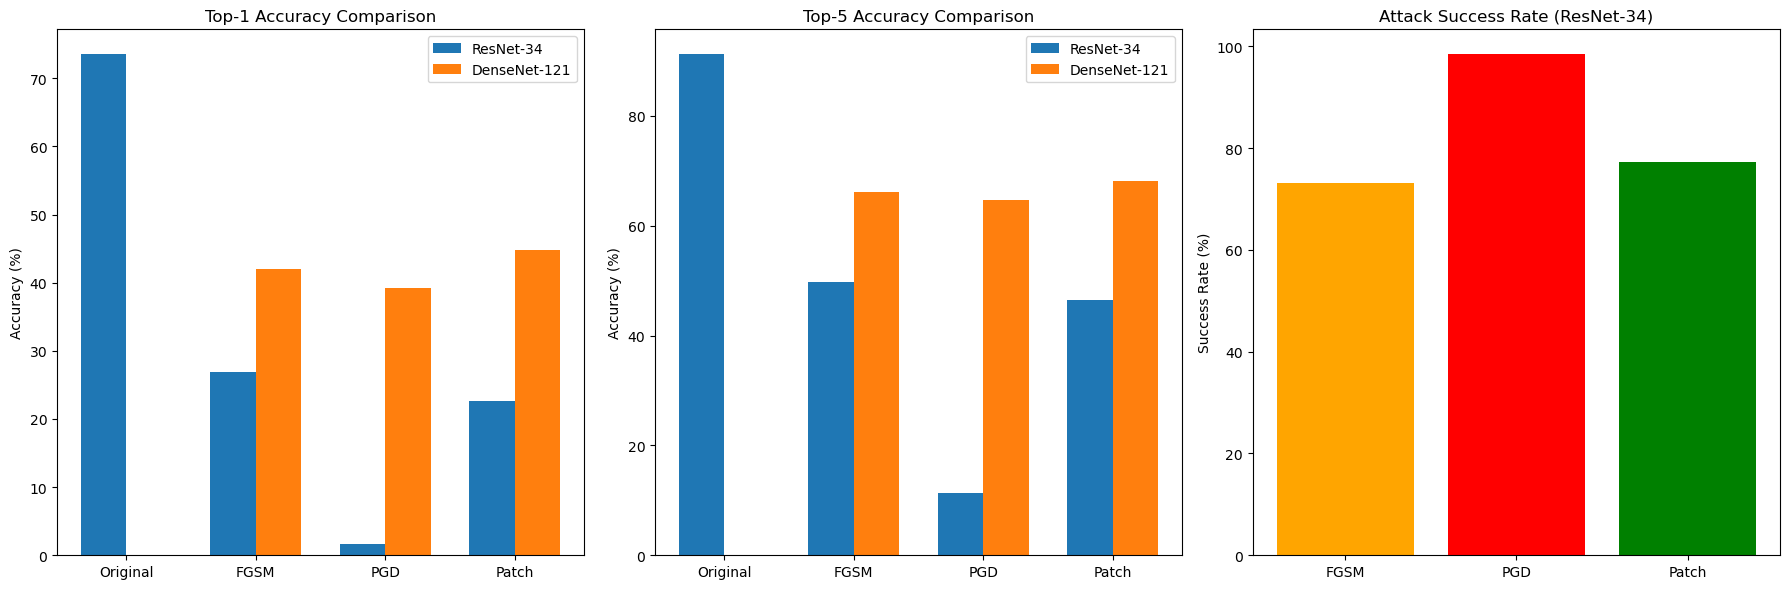

In [29]:
# Prepare data
attacks = ['Original', 'FGSM', 'PGD', 'Patch']
x = np.arange(len(attacks))
width = 0.35

# Model comparison data
resnet_top1 = [73.5, 26.89, 1.59, 22.71]
resnet_top5 = [91.2, 49.80, 11.35, 46.41]
densenet_top1 = [0.0, 42.03, 39.24, 44.82]
densenet_top5 = [0.0, 66.14, 64.74, 68.13]

# Create figure
plt.figure(figsize=(18, 6))

# Plot 1: Top-1 Accuracy Comparison
plt.subplot(1, 3, 1)
plt.bar(x - width/2, resnet_top1, width, label='ResNet-34')
plt.bar(x + width/2, densenet_top1, width, label='DenseNet-121')
plt.xticks(x, attacks)
plt.ylabel('Accuracy (%)')
plt.title('Top-1 Accuracy Comparison')
plt.legend()

# Plot 2: Top-5 Accuracy Comparison
plt.subplot(1, 3, 2)
plt.bar(x - width/2, resnet_top5, width, label='ResNet-34')
plt.bar(x + width/2, densenet_top5, width, label='DenseNet-121')
plt.xticks(x, attacks)
plt.ylabel('Accuracy (%)')
plt.title('Top-5 Accuracy Comparison')
plt.legend()

# Plot 3: Attack Effectiveness (ResNet-34 only)
plt.subplot(1, 3, 3)
success_rates = [0, 73.11, 98.41, 77.29]
plt.bar(attacks[1:], success_rates[1:], color=['orange', 'red', 'green'])
plt.ylabel('Success Rate (%)')
plt.title('Attack Success Rate (ResNet-34)')

plt.tight_layout()
plt.savefig('full_analysis.png')
plt.show()